对特征之间的关系进行简单的认识之后，需要对数据进行预处理，对特征进行处理，进而构建模型。  
+ 数据清洗：缺失值，异常值，一致性；  
+ 特征编码：one-hot 和 label coding；  
+ 特征分箱：等频，等距，聚类等；  
+ 衍生变量：可解释性强，适合模型输入；  
+ 特征选择：方差选择，卡方选择，正则化等；



In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('seaborn')
import re
import numpy as np
from sklearn.ensemble import ExtraTreesRegressor,RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import KFold,cross_val_score

train_path='./train.csv'
test_path='./test.csv'

train_df=pd.read_csv(train_path)
test_df=pd.read_csv(test_path)
df=train_df.append(test_df)

C:\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


## 数据清洗



1.缺失值处理




In [2]:
df[df['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
152,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [3]:
df.loc[(df['Pclass']==3)&(df['Age']>60)&(df['Sex']=='male')]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
116,70.5,NaN,Q,7.7500,"Connors, Mr. Patrick",0,117,3,male,0,0.0,370369
280,65.0,NaN,Q,7.7500,"Duane, Mr. Frank",0,281,3,male,0,0.0,336439
326,61.0,NaN,S,6.2375,"Nysveen, Mr. Johan Hansen",0,327,3,male,0,0.0,345364
851,74.0,NaN,S,7.7750,"Svensson, Mr. Johan",0,852,3,male,0,0.0,347060
152,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [4]:
fare=df.loc[(df['Pclass']==3)&(df['Age']>60)&(df['Sex']=='male'),'Fare'].mean()
df['Fare'].fillna(fare,inplace=True)

Fare特征缺失值只有一个，故可以直接删除或者补充。  
这里采用`相似特征替换`的方法补充缺失值。根据Pclass、Age、Sex重要特征进行查找，用其均值进行填充。



In [5]:
df[df['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


C:\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


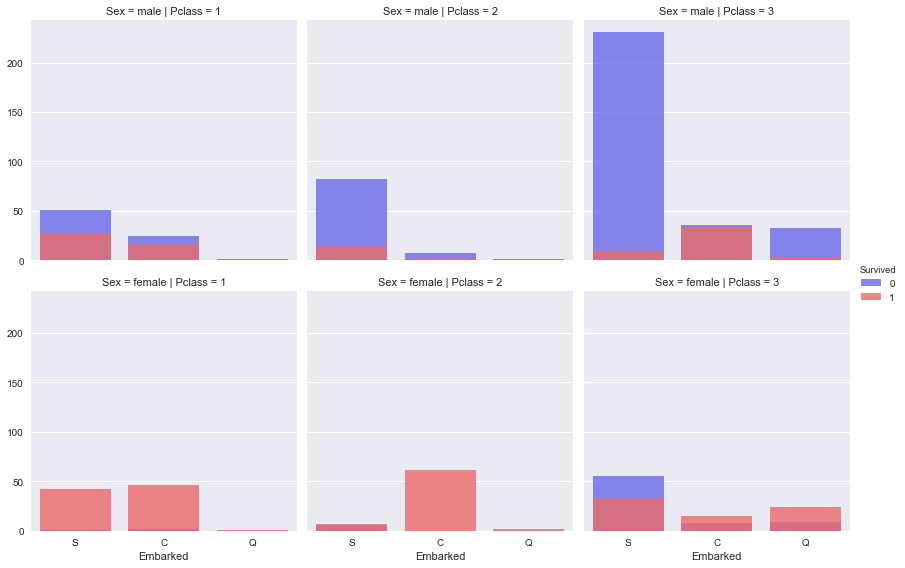

In [6]:
%matplotlib inline
grid = sns.FacetGrid(train_df, row='Sex', col='Pclass', hue='Survived', palette='seismic', size=4)
grid.map(sns.countplot, 'Embarked', alpha=0.8)
grid.add_legend()
plt.show()

In [7]:
df['Embarked'].fillna('C',inplace=True)

Embarked特征补充，pclass1且为女性的情况下，Q港口几乎为0，而C港口最多，其次S港口。  
采用出现最多的港口也就是`众数`C港口进行填补



In [8]:
df['CabinCat']=pd.Categorical(df['Cabin'].fillna('0').apply(lambda x:x[0])).codes
df['Cabin'].fillna('0').apply(lambda x:x[0]).value_counts()

0    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: Cabin, dtype: int64

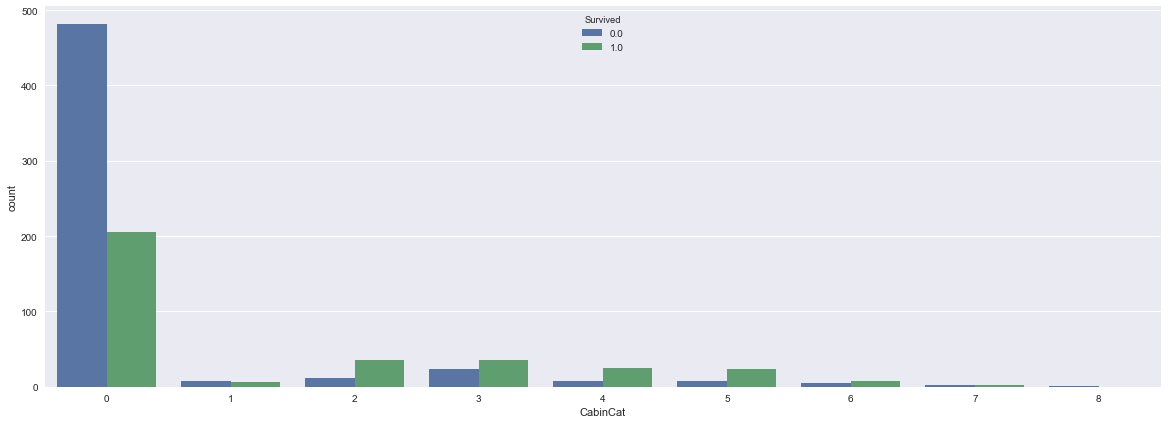

In [9]:
fig,ax=plt.subplots(figsize=(20,7))
sns.countplot(x='CabinCat',hue='Survived',data=df)
plt.show()

In [10]:
def get_type_cabine(cabine):
    # Use a regular expression to search for a title.
    cabine_search = re.search('\d+', cabine)
    # If the title exists, extract and return it.
    if cabine_search:
        num = cabine_search.group(0)
        if np.float64(num) % 2 == 0:
            return '2'
        else:
            return '1'
    return '0'
df["Cabin"] = df["Cabin"].fillna(" ")
df["CabinType"] = df["Cabin"].apply(get_type_cabine)

Cain特征有70%的缺失值，较为严重，如果进行大量的填补会引入更多噪声。  
这里将Cabin缺失值视为一种特殊的值来处理：  
+ 根据Cabin首个字符衍生一个新的特征CabinCat。  
+ 奇偶特征衍生出CabinType。



2.数据转换-衍生变量

Name特征衍生：  
+ 根据姓氏生成surname特征
+ 根据称呼生成Title特征  
+ 根据称呼映射表生成TitleCat特征  
+ 根据Name长度生成NameLength特征

In [11]:
df['surname']=df['Name'].apply(lambda x:x.split(',')[0].lower())
df['Title']=df['Name'].apply(lambda x:re.search(' ([A-Za-z]+)\.', x).group(1))

In [12]:
df['Title'].value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Ms            2
Mlle          2
Major         2
Jonkheer      1
Lady          1
Capt          1
Countess      1
Sir           1
Mme           1
Don           1
Dona          1
Name: Title, dtype: int64

Title类别特别多，但是多数样本集中在少数几类中，所以将一些小类合并到大类中或者小类互相合并。

In [13]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 2, "Mme": 3,"Don": 9,"Dona": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2}
df['TitleCat']=df.loc[:,'Title'].map(title_mapping)
df['NameLength']=df['Name'].apply(lambda x:len(x))

SibSp与Parch特征衍生：  
+ 合并生成Familysize特征，并进行分箱处理。



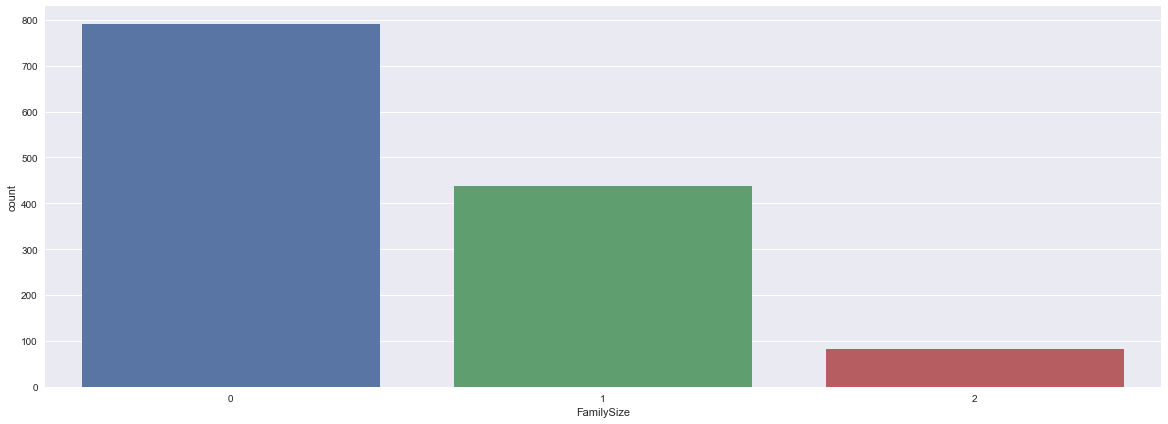

In [14]:
df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
df["FamilySize"]=pd.cut(df["FamilySize"],bins=[0,1,4,20],labels=[0,1,2])
fig,ax=plt.subplots(figsize=(20,7))
sns.countplot(x='FamilySize',data=df,ax=ax)
plt.show()

In [15]:
# Embarked特征量化
df['Embarked']=pd.Categorical(df['Embarked']).codes

In [16]:
# Sex特征独热编码
df=pd.concat([df,pd.get_dummies(df['Sex'])],axis=1)

Age与Sex特征衍生：  
+ person特征：child，female_adult， male_adult

In [17]:
child_age=18
def get_person(passenger):
    age,sex=passenger
    if age<child_age:
        return 'child'
    elif sex=='female':
        return 'female_adult'
    else:
        return 'male_adult'
df=pd.concat([df,pd.DataFrame(df[['Age', 'Sex']].apply(get_person,axis=1),columns=['person'])],axis=1)
df=pd.concat([df,pd.get_dummies(df['person'])],axis=1)

Ticket特征衍生：  
+ 根据Ticket数目进行分箱操作生成Ticket_Members特征  
+ 根据生存与性别得到Ticket_perishing_women与Ticket_surviving_men特征  
+ 根据Ticket类别进行编码得到Ticket_Id特征

In [18]:
table_ticket = pd.DataFrame(df["Ticket"].value_counts())
table_ticket.rename(columns={'Ticket':'Ticket_Members'}, inplace=True)
table_ticket['Ticket_perishing_women'] = df.Ticket[(df.female_adult == 1.0)
                                    & (df.Survived == 0.0)
                                    & ((df.Parch > 0) | (df.SibSp > 0))].value_counts()
table_ticket['Ticket_perishing_women'] = table_ticket['Ticket_perishing_women'].fillna(0)
table_ticket['Ticket_perishing_women'][table_ticket['Ticket_perishing_women'] > 0] = 1.0

table_ticket['Ticket_surviving_men'] = df.Ticket[(df.male_adult == 1.0)
                                    & (df.Survived == 1.0)
                                    & ((df.Parch > 0) | (df.SibSp > 0))].value_counts()
table_ticket['Ticket_surviving_men'] = table_ticket['Ticket_surviving_men'].fillna(0)
table_ticket['Ticket_surviving_men'][table_ticket['Ticket_surviving_men'] > 0] = 1.0

table_ticket["Ticket_Id"]= pd.Categorical(table_ticket.index).codes
# compress under 3 members into one code.
table_ticket["Ticket_Id"][table_ticket["Ticket_Members"] < 3 ] = -1
table_ticket["Ticket_Members"] = pd.cut(table_ticket["Ticket_Members"], bins=[0,1,4,20], labels=[0,1,2])

df = pd.merge(df, table_ticket, left_on="Ticket",right_index=True,how='left', sort=False)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


surname特征衍生：  
与Ticket处理方法相同


In [19]:
table_surname = pd.DataFrame(df["surname"].value_counts())
table_surname.rename(columns={'surname':'Surname_Members'}, inplace=True)

table_surname['Surname_perishing_women'] = df.surname[(df.female_adult == 1.0)
                                    & (df.Survived == 0.0)
                                    & ((df.Parch > 0) | (df.SibSp > 0))].value_counts()
table_surname['Surname_perishing_women'] = table_surname['Surname_perishing_women'].fillna(0)
table_surname['Surname_perishing_women'][table_surname['Surname_perishing_women'] > 0] = 1.0

table_surname['Surname_surviving_men'] = df.surname[(df.male_adult == 1.0)
                                    & (df.Survived == 1.0)
                                    & ((df.Parch > 0) | (df.SibSp > 0))].value_counts()
table_surname['Surname_surviving_men'] = table_surname['Surname_surviving_men'].fillna(0)
table_surname['Surname_surviving_men'][table_surname['Surname_surviving_men'] > 0] = 1.0

table_surname["Surname_Id"]= pd.Categorical(table_surname.index).codes
# compress under 3 members into one code.
table_surname["Surname_Id"][table_surname["Surname_Members"] < 3 ] = -1

table_surname["Surname_Members"] = pd.cut(table_surname["Surname_Members"], bins=[0,1,4,20], labels=[0,1,2])

df = pd.merge(df, table_surname, left_on="surname",right_index=True,how='left', sort=False)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Age缺失值填充：这里将利用其它特征进行预测填补Age，也就是拟合未知Age特征值。

In [ ]:
classers = ['Fare','Parch','Pclass','SibSp','TitleCat',
'CabinCat','female','male', 'Embarked', 'FamilySize', 'NameLength','Ticket_Members','Ticket_Id']
from sklearn.ensemble import ExtraTreesRegressor,RandomForestClassifier
import numpy as np
x_train=df[classers][df['Age'].notnull()]
y_train=df['Age'][df['Age'].notnull()]
x_test=df[classers][df['Age'].isnull()]

etr=ExtraTreesRegressor(n_estimators=200)
etr.fit(x_train,np.ravel(y_train))
pred_age=etr.predict(x_test)
df['Age'][df['Age'].isnull()]=pred_age

## 特征选择

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 33 columns):
Age                        1309 non-null float64
Cabin                      1309 non-null object
Embarked                   1309 non-null int8
Fare                       1309 non-null float64
Name                       1309 non-null object
Parch                      1309 non-null int64
PassengerId                1309 non-null int64
Pclass                     1309 non-null int64
Sex                        1309 non-null object
SibSp                      1309 non-null int64
Survived                   891 non-null float64
Ticket                     1309 non-null object
CabinCat                   1309 non-null int8
CabinType                  1309 non-null object
surname                    1309 non-null object
Title                      1309 non-null object
TitleCat                   1309 non-null int64
NameLength                 1309 non-null int64
FamilySize                 1309 non-nu

In [23]:
features = ['female','male','Age','male_adult','female_adult', 'child','TitleCat', 'Pclass',
'Ticket_Id','NameLength','CabinType','CabinCat', 'SibSp', 'Parch',
'Fare','Embarked','Surname_Members','Ticket_Members','FamilySize',
'Ticket_perishing_women','Ticket_surviving_men',
'Surname_perishing_women','Surname_surviving_men']

train=df[0:891].copy()
test=df[891:].copy()

selector=SelectKBest(f_classif,k=len(features))
selector.fit(train[features],train['Survived'])
scores = -np.log10(selector.pvalues_)
indices = np.argsort(scores)[::-1]
print("Features importance :")
for f in range(len(scores)):
    print("%0.2f %s" % (scores[indices[f]],features[indices[f]]))

#可以设置分数阈值选择特征，这里使用全部特征
# features=np.asarray(features)[scores>10].tolist()

Features importance :
68.85 female
68.85 male
64.90 male_adult
53.23 female_adult
26.22 TitleCat
24.60 Pclass
23.69 NameLength
17.75 CabinCat
17.00 Ticket_surviving_men
16.28 CabinType
14.21 Fare
13.54 Ticket_perishing_women
13.04 Surname_surviving_men
10.36 Surname_perishing_women
6.78 Embarked
5.27 Ticket_Members
3.59 child
2.93 FamilySize
1.83 Parch
1.68 Age
1.07 Ticket_Id
0.73 Surname_Members
0.53 SibSp


## 模型训练



In [25]:
rfc=RandomForestClassifier(n_estimators=3000,min_samples_split=4,class_weight={0:0.745,1:0.255})
kf=KFold(n_splits=3,shuffle=True,random_state=1)
scores=cross_val_score(rfc,train[features],train['Survived'],cv=kf)
print("Accuracy: %0.3f (+/- %0.2f) [%s]" % (scores.mean()*100, scores.std()*100, 'RFC Cross Validation'))
rfc.fit(train[features],train['Survived'])
score=rfc.score(train[features],train['Survived'])
print("Accuracy: %0.3f            [%s]" % (score*100, 'RFC full test'))

importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(len(features)):
    print("%d. feature %d (%f) %s" % (f + 1, indices[f]+1, importances[indices[f]]*100, features[indices[f]]))

rfc.fit(train[features], train['Survived'])
predictions = rfc.predict(test[features])

Accuracy: 89.113 (+/- 1.95) [RFC Cross Validation]
Accuracy: 96.409            [RFC full test]
1. feature 15 (9.501022) Fare
2. feature 3 (9.126446) Age
3. feature 10 (8.500409) NameLength
4. feature 20 (7.565634) Ticket_perishing_women
5. feature 22 (7.323488) Surname_perishing_women
6. feature 7 (6.930558) TitleCat
7. feature 2 (6.785721) male
8. feature 1 (5.895008) female
9. feature 8 (5.141321) Pclass
10. feature 4 (4.784949) male_adult
11. feature 21 (4.765418) Ticket_surviving_men
12. feature 5 (3.607805) female_adult
13. feature 18 (2.951380) Ticket_Members
14. feature 12 (2.840628) CabinCat
15. feature 19 (2.438454) FamilySize
16. feature 23 (2.399362) Surname_surviving_men
17. feature 17 (1.971574) Surname_Members
18. feature 11 (1.894477) CabinType
19. feature 16 (1.664470) Embarked
20. feature 9 (1.338257) Ticket_Id
21. feature 13 (1.189016) SibSp
22. feature 6 (0.700342) child
23. feature 14 (0.684261) Parch


## 保存结果

In [26]:
PassengerId =np.array(test["PassengerId"]).astype(int)
my_prediction = pd.DataFrame({'PassengerId':PassengerId, 'Survived':predictions.astype('int')})
my_prediction.to_csv("my_prediction.csv", index=False)